# 감자봉사 데이터 분석

In [1]:
!pip install requests seaborn pandas matplotlib

## API 사용을 위한 함수 정의(1365 API, 카카오 로컬 API)

개인 API키 사용

In [2]:
import requests
import xml.etree.ElementTree as ET
import re

API_KEY = '4p0XVPTEI9PZjKGVgg60JYy455iyV9dr8bC0rpEGm4Ol5hUZqeKSiC%2FX5SPcdgKyAKLGVWtp5gpbrP27Pw%2BrBw%3D%3D'

KAKAO_API_KEY = "56cf8de98367cd83a483b1ae9e00b575"

BASE_URL = 'http://openapi.1365.go.kr/openapi/service/rest/VolunteerPartcptnService/'

def get_volunteer_participation_list(start_date, end_date, num_of_rows=10, page_no=1, sido_code=None, gugun_code=None):
    url = f"{BASE_URL}getVltrPeriodSrvcList"
    
    params = {
        'ServiceKey': API_KEY,
        'progrmBgnde': start_date,
        'progrmEndde': end_date,
        'numOfRows': num_of_rows,
        'pageNo': page_no
    }
    
    if sido_code:
        params['schSido'] = sido_code
    if gugun_code:
        params['schSign1'] = gugun_code
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        items = root.find('.//items')
        volunteer_list = []

    
        for item in items.findall('item'):
            volunteer = {
                'program_no': item.findtext('progrmRegistNo'),
                'title': item.findtext('progrmSj'),
                'organization': item.findtext('nanmmbyNm'),
                'start_date': item.findtext('progrmBgnde'),
                'end_date': item.findtext('progrmEndde'),
                'status': item.findtext('progrmSttusSe'),
            }
            volunteer_list.append(volunteer)
        
        return volunteer_list
    else:
        print(f"Error: {response.status_code}")
        return None

def get_volunteer_detail(program_no):
    url = f"{BASE_URL}getVltrPartcptnItem"
    
    params = {
        'ServiceKey': API_KEY,
        'progrmRegistNo': program_no
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        item = root.find('.//item')
        details = {
            'program_no': item.findtext('progrmRegistNo'),
            'title': item.findtext('progrmSj'),
            'status' : item.findtext('progrmSttusSe'),
            'notice_start_date': item.findtext('progrmBgnde'),
            'notice_end_date': item.findtext('noticeBgnde'),
            'act_start_date' : item.findtext('progrmBgnde'),
            'act_end_date' : item.findtext('noticeEndde'),
            'act_start_time': item.findtext('actBeginTm'),
            'act_end_time': item.findtext('actEndTm'),
            'location': item.findtext('actPlace'),
            'contact': item.findtext('telno'),
            'description': item.findtext('progrmCn'),
            'recruit' : item.findtext('rcritNmpr'),
            'weekday' : item.findtext('actWkdy'),
            'category' : item.findtext('srvcClCode'),
            'isadult' : item.findtext('adultPosblAt'),
            'isteen' : item.findtext('yngbgsPosblAt'),
            'isgroup' : item.findtext('grpPosblAt'),
            'host_place' : item.findtext('mnnstNm'),
            'regist_place' : item.findtext('nanmmbyNm'),
            'si_code' : item.findtext('gugunCd'),
            'manager_adress' : item.findtext('postAdres')
        }
        return details
    else:
        print(f"Error: {response.status_code}")
        return None


def get_coordinates_by_keyword(address):
    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    
    headers = {
        "Authorization": f"KakaoAK {KAKAO_API_KEY}"
    }
    
    params = {
        "query": address
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        result = response.json()
        if result['documents']:
            # 첫 번째 검색 결과의 경도(x)와 위도(y)를 반환
            x = result['documents'][0]['x']
            y = result['documents'][0]['y']
            return x, y
        else:
            return get_coordinates_by_adress(adress)            
    else:
        print(f"API 요청 실패: {response.status_code}")
        return None

def get_coordinates_by_adress(address):
    url = "https://dapi.kakao.com/v2/local/search/address.json"
    
    headers = {
        "Authorization": f"KakaoAK {KAKAO_API_KEY}"
    }
    
    params = {
        "query": address
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        result = response.json()
        if result['documents']:
            x = result['documents'][0]['x']
            y = result['documents'][0]['y']
            return x, y
        else:
            print("주소를 찾을 수 없습니다.")
            return None
    else:
        print(f"API 요청 실패: {response.status_code}")
        return None

## 24년 8월 1일부터 31일까지의 데이터 사용. 기반별 API로 조회

In [3]:
i = 1
program_list = []
result = get_volunteer_participation_list('20240801', '20240831', num_of_rows=20, page_no=i)
while len(result) != 0 :
    program_list = program_list + result
    i = i + 1
    result = get_volunteer_participation_list('20240801', '20240831', num_of_rows=20, page_no=i)
    
print(program_list)

[{'program_no': '3175617', 'title': '(온라인) 청소년 자원봉사 온라인교육 - 봉사시간 1시간 인정', 'organization': '거제시자원봉사센터', 'start_date': '20240821', 'end_date': '20241120', 'status': '2'}, {'program_no': '3168411', 'title': '온라인자원봉사기초교육1.2(온라인신청불가)', 'organization': '제천시종합자원봉사센터', 'start_date': '20240801', 'end_date': '20241031', 'status': '2'}, {'program_no': '3154478', 'title': '[옥인육아어울림센터] 장난감도서관 장난감 소독 및 정리 (화,토 13시~17시)', 'organization': '종로구육아종합지원센터', 'start_date': '20240801', 'end_date': '20241031', 'status': '2'}, {'program_no': '3164971', 'title': '오전반★ 서울동물복지지원센터(마포) 유기견 산책 및 관리 자원봉사자 모집 재공고 (3차, 8~10월) ', 'organization': '서울특별시 동물보호과', 'start_date': '20240801', 'end_date': '20241031', 'status': '3'}, {'program_no': '3165091', 'title': '서울동물복지지원센터(마포) 유기견 촬영 자원봉사자 (3차 8월 ~ 10월) ', 'organization': '서울특별시 동물보호과', 'start_date': '20240801', 'end_date': '20241031', 'status': '2'}, {'program_no': '3164937', 'title': '오후반★ 서울동물복지지원센터(마포) 유기견 산책 및 관리 자원봉사자 재공고(3차 8월 ~ 10월) ', 'organization': '서울특별시 동물보호

In [4]:
len(program_list)

1395

## 상세 정보 및 카카오 로컬을 통한 좌표 획득

In [5]:
detail_list = []

if program_list:
    for volunteer in program_list:
        print(f"Program: {volunteer['title']} (#{volunteer['program_no']})")
        
        detail = get_volunteer_detail(volunteer['program_no'])
        adress = detail['location']
        pruned_adr = re.sub(r'\([^]]*\)', '', adress)
        detail.update({"pruned_adress" : pruned_adr})
        cord = get_coordinates_by_keyword(pruned_adr)
        detail.update({"coordinates" : cord})
        
        detail_list.append(detail)

Program: (온라인) 청소년 자원봉사 온라인교육 - 봉사시간 1시간 인정 (#3175617)
Program: 온라인자원봉사기초교육1.2(온라인신청불가) (#3168411)
Program: [옥인육아어울림센터] 장난감도서관 장난감 소독 및 정리 (화,토 13시~17시) (#3154478)
주소를 찾을 수 없습니다.
Program: 오전반★ 서울동물복지지원센터(마포) 유기견 산책 및 관리 자원봉사자 모집 재공고 (3차, 8~10월)  (#3164971)
Program: 서울동물복지지원센터(마포) 유기견 촬영 자원봉사자 (3차 8월 ~ 10월)  (#3165091)
Program: 오후반★ 서울동물복지지원센터(마포) 유기견 산책 및 관리 자원봉사자 재공고(3차 8월 ~ 10월)  (#3164937)
Program: 구립한남데이케어센터 어르신 활동 보조 및 말벗 도움 (#3154364)
주소를 찾을 수 없습니다.
Program: (생활체육, 미술, 원예 등) 재능기부 자원봉사자를 모집합니다. (#3168417)
Program: 프로그램 보조 및 식사수발 (10:00~14:00, 4시간) (#3164321)
Program: 프로그램 보조 및 말벗 (14:00~18:00, 4시간) (#3164320)
Program: 학교도서관봉사 (#3174854)
주소를 찾을 수 없습니다.
Program: 재능나눔 공연봉사 (#3164323)
Program: 북카페관리 : 책정리 및 청소 (오후 - 13:00 ~ 17:00) (#3175716)
Program: 북카페관리 : 책정리 및 청소 (오전 - 09:00 ~ 13:00) (#3175714)
Program: 안내데스크 : 면회객안내(오전 - 09:00 ~ 13:00) (#3172691)
Program: 안내데스크 : 면회객안내(오후 - 13:00 ~ 17:00) (#3172695)
Program: (오후) 답십리영화미디어아트센터 자원봉사자 모집 (#3161288)
Program: (오전) 답십리영화미디어아트센터 자원봉사자 모

In [6]:
len(detail_list)

1395

# 데이터 분석

In [7]:
import pandas as pd

In [8]:
df = pd.DataFrame.from_dict(detail_list)

혹은 저장된 CSV에서 불러오기

```python

df = pd.DataFrame.read_csv('1365_data_240801to31.csv')

```

In [9]:
df

,program_no,title,status,notice_start_date,notice_end_date,act_start_date,act_end_date,act_start_time,act_end_time,location,...,category,isadult,isteen,isgroup,host_place,regist_place,si_code,manager_adress,pruned_adress,coordinates
0,3175617,(온라인) 청소년 자원봉사 온라인교육 - 봉사시간 1시간 인정,2,20240821,20240821,20240821,20241120,0,23,온라인,...,자원봉사교육 > 자원봉사기타교육.기타교육,N,Y,N,거제시자원봉사센터,경상남도 거제시,5370000,경상남도 거제시 고현로 2길 42 (고현동) 2층,온라인,"(126.97367244198514, 37.578073021010816)"
1,3168411,온라인자원봉사기초교육1.2(온라인신청불가),2,20240801,20240801,20240801,20241031,9,21,온라인,...,자원봉사교육 > 자원봉사기본교육,Y,Y,N,제천시종합자원봉사센터,충청북도 제천시,4400000,충청북도 제천시 내토로35길 17 (화산동),온라인,"(126.97367244198514, 37.578073021010816)"
2,3154478,"[옥인육아어울림센터] 장난감도서관 장난감 소독 및 정리 (화,토 13시~17시)",2,20240801,20240701,20240801,20241031,13,17,옥인육아어울림센터 2층 장난감도서관,...,기타 > 기타,Y,N,N,종로구육아종합지원센터,서울특별시 종로구,3000000,"서울특별시 종로구 성균관로1길 6-3 (명륜3가, 종로구육아종합지원센터) 3층 종로...",옥인육아어울림센터 2층 장난감도서관,None
3,3164971,오전반★ 서울동물복지지원센터(마포) 유기견 산책 및 관리 자원봉사자 모집 재공고 (...,3,20240801,20240725,20240801,20241031,10,12,"서울특별시 마포구 매봉산로 31 (상암동, S-PLEX CENTER) 지하 1층 서...",...,기타 > 기타,Y,N,N,서울특별시 동물보호과,서울특별시 중구,3010000,서울특별시 마포구 매봉산로 31 에스플렉스 지하 1층 서울동물복지지원센터,서울특별시 마포구 매봉산로 31 지하 1층 서울동물복지지원센터,"(126.889972593033, 37.5757269662412)"
4,3165091,서울동물복지지원센터(마포) 유기견 촬영 자원봉사자 (3차 8월 ~ 10월),2,20240801,20240725,20240801,20241031,13,16,"서울특별시 마포구 매봉산로 31 (상암동, S-PLEX CENTER) 지하 1층 서...",...,기타 > 기타,Y,N,N,서울특별시 동물보호과,서울특별시 중구,3010000,서울특별시 마포구 매봉산로 31 에스플렉스 지하 1층 서울동물복지지원센터,서울특별시 마포구 매봉산로 31 지하 1층 서울동물복지지원센터,"(126.889972593033, 37.5757269662412)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,3167107,"[요양병원]말벗봉사, 산책봉사, 식사보조봉사",2,20240801,20240730,20240801,20241027,13,17,중앙요양병원,...,생활편의지원 > 활동보조,Y,Y,N,의료법인 선은의료재단,세종특별자치시 세종시,5690001,세종특별자치시 조치원읍 섭골길 37(중앙요양병원) 1층,중앙요양병원,"(128.551188730665, 35.8319830807961)"
1391,3167990,LH다가온 작은도서관 서비스 보조,2,20240801,20240801,20240801,20241030,13,17,가온마을9단지 LH다가온작은도서관(관리사무소 옆),...,생활편의지원 > 활동보조,Y,Y,N,다가온작은도서관,세종특별자치시 세종시,5690001,세종특별자치시 다정북로 183 LH다가온작은도서관,가온마을9단지 LH다가온작은도서관,None
1392,3167685,"활동보조, 청소 및업무보조",2,20240801,20240801,20240801,20241031,9,17,사회적협동조합국민행복,...,생활편의지원 > 활동보조,Y,N,N,사회적협동조합 국민행복,세종특별자치시 세종시,5690001,"세종특별자치시 고운서길 7(고운동, 골드프라자) 501호",사회적협동조합국민행복,None
1393,3172099,어르신 활동보조 자원봉사,2,20240812,20240812,20240812,20241011,9,12,이룬요양원,...,생활편의지원 > 활동보조,Y,N,N,이룬요양원,세종특별자치시 세종시,5690001,세종특별자치시 조치원읍 문화6길 6 이룬요양원,이룬요양원,"(127.288668998266, 36.6015302238033)"


In [10]:
df.isnull().sum()

program_no             0
title                  0
status                 0
notice_start_date      0
notice_end_date        0
act_start_date         0
act_end_date           0
act_start_time         0
act_end_time           0
location               0
contact                0
description            0
recruit                0
weekday                3
category               0
isadult                0
isteen                 0
isgroup                0
host_place             0
regist_place           0
si_code                0
manager_adress         0
pruned_adress          0
coordinates          477
dtype: int64

In [26]:
df['pruned_adress'].str.contains('온라인|비대면').sum()

13

In [11]:
distribution_summary = df.describe(include='all')

distribution_summary

,program_no,title,status,notice_start_date,notice_end_date,act_start_date,act_end_date,act_start_time,act_end_time,location,...,category,isadult,isteen,isgroup,host_place,regist_place,si_code,manager_adress,pruned_adress,coordinates
count,1395,1395,1395,1395,1395,1395,1395,1395,1395,1395,...,1395,1395,1395,1395,1395,1395,1395,1395,1395,918
unique,1395,1351,2,31,78,31,70,17,19,1081,...,50,2,2,1,966,173,173,986,1080,680
top,3175617,어르신 활동보조,2,20240801,20240801,20240801,20241031,9,17,시립동대문실버케어센터,...,생활편의지원 > 활동보조,Y,N,N,시립동대문실버케어센터,경기도 수원시,3740000,서울특별시 동대문구 황물로 12 시립동대문실버케어센터,시립동대문실버케어센터,"(127.04491943544203, 37.57584736060709)"
freq,1,5,1234,457,186,457,343,368,294,14,...,275,1367,871,1395,14,43,43,14,14,18


### 데이터 CSV 출력

In [12]:
df.to_csv('1365_data_240801to31')

## 시각화

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

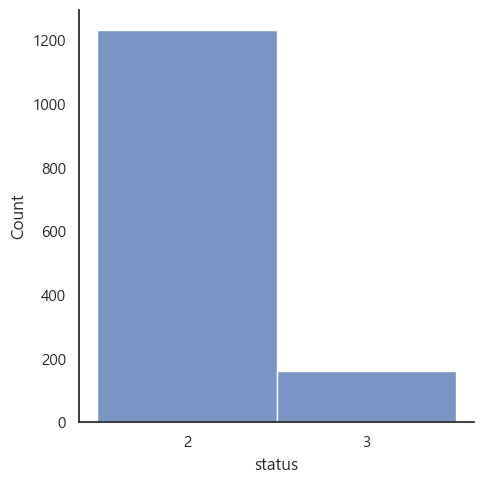

In [14]:
sns.displot(data = df['status'])
plt.savefig('staus.png')

모집상태
 - 1 : 모집대기
 - 2 : 모집중
 - 3 : 모집완료

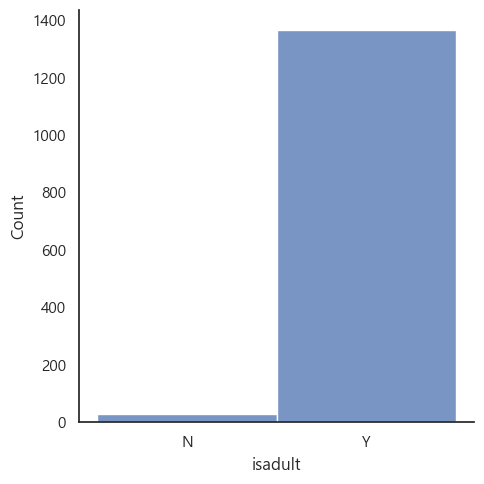

In [15]:
sns.displot(data = df['isadult'])
plt.savefig('adult.png')

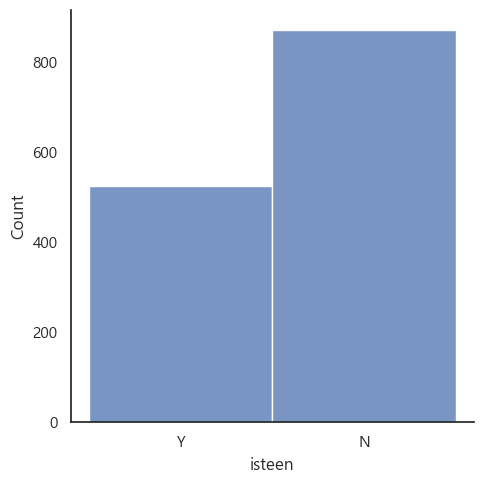

In [16]:
sns.displot(data = df['isteen'])
plt.savefig('teen.png')

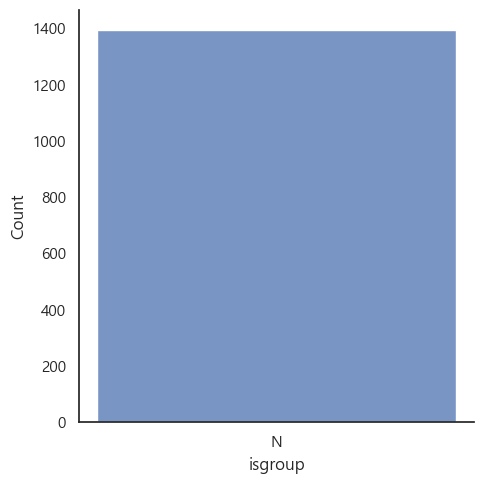

In [17]:
sns.displot(data = df['isgroup'])
plt.savefig('group.png')

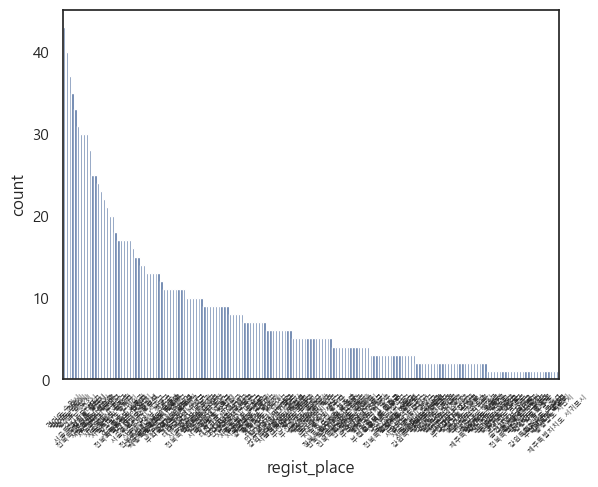

In [18]:
place_counts = df['regist_place'].value_counts()

df['regist_place'] = pd.Categorical(df['regist_place'], categories=place_counts.index, ordered=True)

sns.countplot(data=df, x='regist_place', order=place_counts.index)
plt.xticks(rotation=45, fontsize=5)
plt.savefig('place.png')

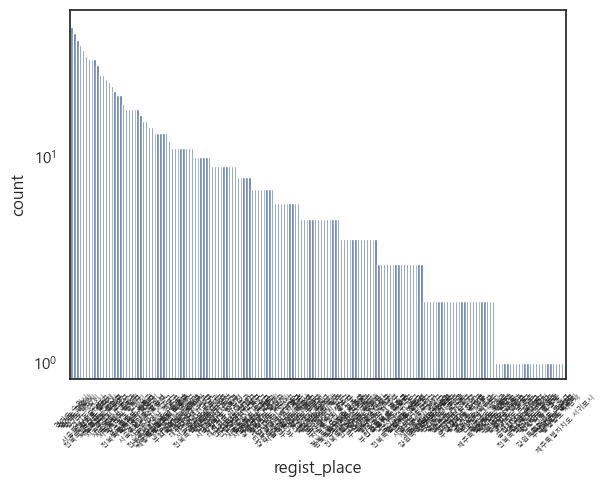

In [19]:
sns.countplot(data=df, x='regist_place', order=place_counts.index)
plt.yscale('log')
plt.xticks(rotation=45, fontsize=5)
plt.savefig('placelog.png')

In [20]:
len(place_counts)

173

In [21]:
place_counts

regist_place
경기도 수원시         43
경기도 고양시         40
경기도 안양시         37
경기도 안산시         35
경기도 화성시         33
                ..
부산광역시 금정구        1
전라남도 영암군         1
전라남도 목포시         1
충청남도 서산시         1
제주특별자치도 서귀포시     1
Name: count, Length: 173, dtype: int64

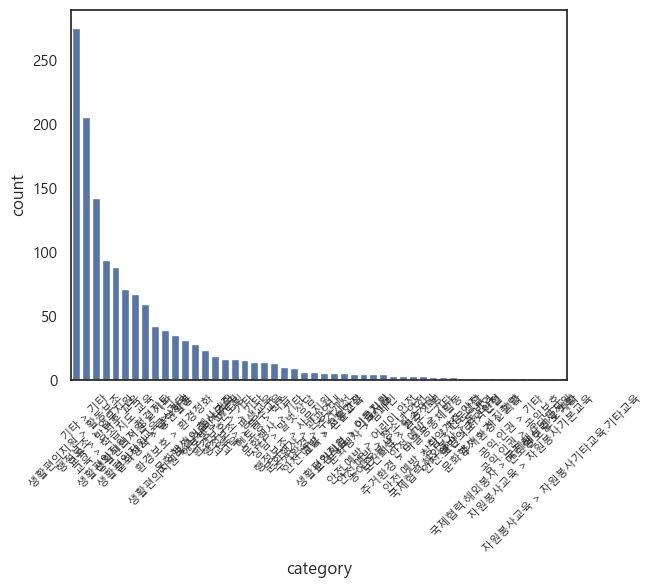

In [22]:
category = df['category'].value_counts()

df['category'] = pd.Categorical(df['category'], categories=category.index, ordered=True)

sns.countplot(data=df, x='category', order=category.index)
plt.xticks(rotation=45, fontsize=8)
plt.savefig('category.png')

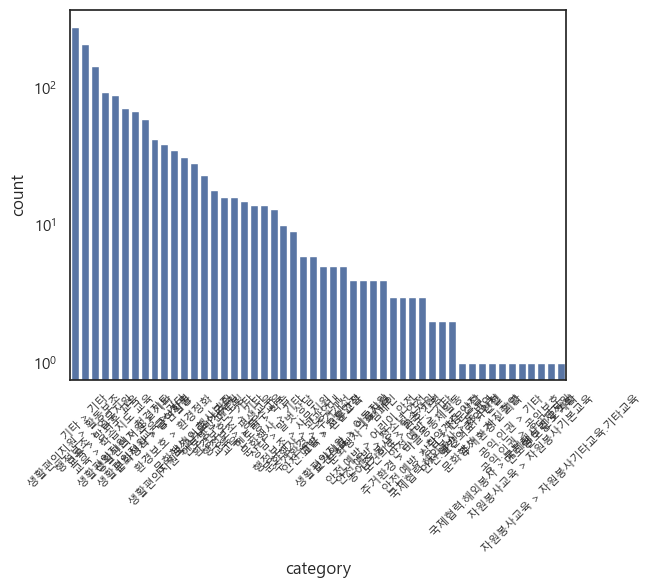

In [23]:
sns.countplot(data=df, x='category', order=category.index)
plt.xticks(rotation=45, fontsize=8)
plt.yscale('log')
plt.savefig('categorylog.png')

In [24]:
len(category)

50

In [25]:
category

category
생활편의지원 > 활동보조             275
기타 > 기타                   205
행정보조 > 업무지원               142
교육 > 방과후 교육                93
교육 > 학습지도 교육               88
생활편의지원 > 청결지도              71
생활편의지원 > 기타                67
생활편의지원 > 급식지원              59
문화행사 > 공연활동                42
교육 > 기타                    39
환경보호 > 환경정화                35
생활편의지원 > 식사.반찬지원           31
문화행사 > 행사보조                28
보건의료 > 기타                  23
멘토링 > 멘토링                  18
환경보호 > 기타                  16
행정보조 > 기타                  16
교육 > 평생교육                  15
교육 > 특수교육                  14
멘토링 > 학습                   14
문화행사 > 기타                  13
상담 > 말벗.상담                 10
행정보조 > 사무지원                 9
문화행사 > 관광안내                 6
주거환경 > 주거개선                 6
안전.예방 > 교통안전                5
교육 > 전문교육                   5
생활편의지원 > 이동지원               5
보건의료 > 의료지원                 4
문화행사 > 캠페인                  4
안전.예방 > 어린이 안전              4
안전.예방 > 청소년 안전              4
농어촌 봉사 > 일손지원               3
보